# PLONK proof system

PLONK is a general-purpose zero-knowledge proof scheme introduced by Ariel Gabizon, Zac Williamson, and Oana Ciobotaru. The name "PLONK" stands for "Permutations over Lagrange-bases for Oecumenical Noninteractive arguments of Knowledge."

PLONK builds upon previous advancements in general-purpose zero-knowledge proof protocols like SONIC and Marlin. It introduces several enhancements that aim to improve the usability and efficiency of zero-knowledge proofs.

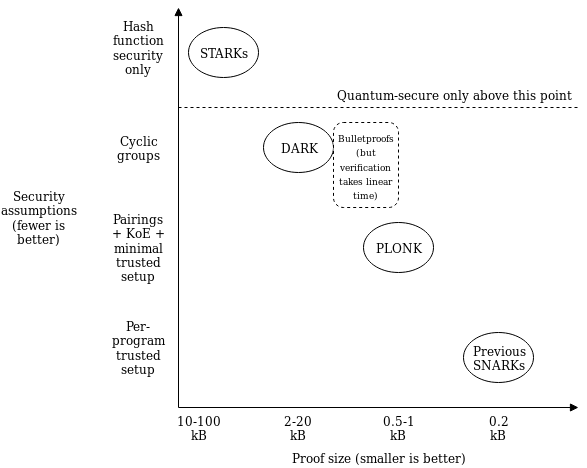

## The key improvements in PLONK
### Universal and Updateable Trusted Setup: 

Like many other zero-knowledge proof schemes, PLONK still requires a trusted setup procedure. In a trusted setup, a set of initial parameters is generated, and the security of the scheme depends on keeping these parameters secret. However, PLONK's trusted setup is universal and updateable. This means that instead of needing a separate trusted setup for each program to be proven, there is one single trusted setup that can be used with any program (up to a certain maximum size defined during setup). Additionally, the trusted setup can involve multiple parties, and it remains secure as long as at least one of the participants is honest. This multi-party procedure is sequential, allowing participants to be added over time, which increases the safety of the setup in practice.

### Standardized Component - Polynomial Commitment
PLONK relies on a single standardized component called a "polynomial commitment." Polynomial commitments are cryptographic tools that enable efficient verification of polynomial equations. PLONK uses "Kate commitments," which are based on trusted setups and elliptic curve pairings. However, the scheme is flexible, allowing alternative schemes like FRI or DARK to be used instead. This means that different trade-offs between proof size and security assumptions can be achieved by swapping out the polynomial commitment scheme. The ability to choose different schemes caters to various use cases and developer preferences.

## Index
1. Prerequesites
2. Example Problem Description
3. Setup Phase
4. Prover Phase
5. Verifier Phase

## 1. Prerequisites

### Field
All operations are taking place in a finite field. A finite field is a field with finitely many elements. Let $p$ be a prime. Then $\mathbb{F}_p$ is defined as the field whose elements are the set of natural numbers ${0,1,…,p−1}$.

- 0 is defined to be 0
- 1 is defined to be 1
- $add(x,y) = (x+y)  \mod  p$
- $sub(x,y) = (x−y)  \mod  p$
- $mul(x,y) = (x⋅y)  \mod  p$
- $div(x,y) = (x⋅y^{p−2})  \mod  p$

### Polynomials
Polynomials are an essential part of every succinct ZKP. We will have to perform a number of multiplications and divisions on polynomials, and this can be done more efficiently in the [Lagrange basis](https://en.wikipedia.org/wiki/Lagrange_polynomial) than in the monomial basis[https://en.wikipedia.org/wiki/Monomial_basis]. We will often need to switch between these representations, which can be done efficiently using [FFTs](https://vitalik.ca/general/2019/05/12/fft.html). The machinery for this in `polynomial_evalrep.py`, and is also taken from the babySNARK repo.

### Roots of unity
The polynomials need to evaluate to very specify values determined by the computation we want to verify. However, we have free choice of the evaluation domain. So instead of just arbitrarily choosing `x = 1, 2…, n`, we select roots of unity as our evaluation domain. Read more on that in [Vitaliks series on STARKs](https://vitalik.ca/general/2017/11/09/starks_part_1.html) tl;dr: it allows for faster FFTs and quick evaluation of a vanishing polynomial.

### Elliptic curves and pairings
Pairings are the secret sauce of many SNARKs such as this one. `ssbls.py` is an implementation of pairing cryptography, including BLS12-381. The BLS12-381 is chosen in part because it's FFT friendly. To use radix-2 FFT, we need to find m^th roots of unity, where m is a power of two, and m is the degree bound of the polynomial we want to represent. In the BLS12-381, we can find primitive n^th roots of unity, for any power of two $n$ up to $n <= 2^{32}$.

In [ ]:
import random

from zkp_playground.algebra.utils import randfield

from zkp_playground.zkp.plonk.polynomial_evalrep import get_omega_base
from zkp_playground.zkp.plonk.polynomial_evalrep import polynomialsEvalRep
from zkp_playground.zkp.plonk.ssbls12 import Fp, Poly, Group

# I am using a Type1 (symmetric) Bilinear group setting for simplicity
G = Group.G
G2 = G
GT = Group.GT

# ROOTS of unity:
# Our example problem will have 6 gates, the next power of two is 8
n = 8
omega_base = get_omega_base(Fp, 2 ** 32, seed=0)
assert n & n - 1 == 0, "n must be a power of 2"
omega = omega_base ** (2 ** 32 // n)
ROOTS = [omega ** i for i in range(n)]

# Polynomials in Lagrange form
PolyEvalRep = polynomialsEvalRep(Fp, omega, n)


## 2. Example Problem Description
We use the example problem from Vitalik's blog and construct a proof that we know `x` so that $x^3 + x + 5 == 35$

### Circuit
Our equation first has to be rewritten into individual operations of addition, multiplication, or constants of the form `a operation b = c` as follows:  
```
   x * x = var1  
var1 * x = var2  
var2 + x = var3  
       5 = 5    
      35 = 35    
var3 + 5 = 35   
```

In the result we obtain four vectors:  

- `a` for the left operands:  `[x, var1, var2, 1, 1 var3]`  
- `b` for the right operands :`[x, x, x, 5, 35, 5]`  
- `c` for the results:       `[var1, var2, var3, 5, 35, 35]`  

`gates_matrix`  for the operations:   `[mul, mul, add, const, const, add]`  

The vector `gates_matrix` represents the gates of our circuit, and the vector `wires` represent all wires of our circuit.

### Gates
The operations are instantiated using constraints of the form: $ (Q_{L_i}) a_i + (Q_{R_i}) b_i + (Q_{O_i}) c_i + (Q_{M_i})a_ib_i + Q_{C_i} = 0$. We turn this general form into the gates we want using these values for the $Qs$:
```
          L   R   M   O   C 
add       1   1   0  -1   0
mul       0   0   1  -1   0  
cons      0   1   0   0 -const  
public    0   1   0   0   0
empty     0   0   0   0   0
```

There are more possible gate constructions, e.g. binary checks, but the ones above are the only ones we need for this example. A side effect of using roots of unity, as mentioned above, is that we need the number of gates has to be a power of two. Therefore, we add two empty gates to our operation vector and to each wire vector.


In [ ]:
# Wires
a = ["x", "var1", "var2", "1","1", "var3", "empty1", "empty2"]
b = ["x", "x", "x", "5","35", "5", "empty3", "empty4"]
c = ["var1", "var2", "var3", "5", "35", "35", "empty5", "empty6"]

wires = a + b + c
    
# Gates
add =          [1, 1, 0, -1,  0]
mul =          [0, 0, 1, -1,  0]
const5 =       [0, 1, 0,  0, -5]
public_input = [0, 1, 0,  0,  0]
empty =        [0, 0, 0,  0,  0]
    
gates_matrix = [mul, mul, add, const5, public_input, add, empty, empty]

### Public inputs
You may have noticed the `public_input` gate above. Although it is not necessarily needed in our example, we allow the prover to freely choose another value instead of 35 just to show this functionality.

In [ ]:
# For the public input we specify the position of the gate and the value
L = [4]
p_i = 35

### Permutation
We now have a number of constraints that theoretically combined represent our computation. But in fact nothing enforces them to be combined. 

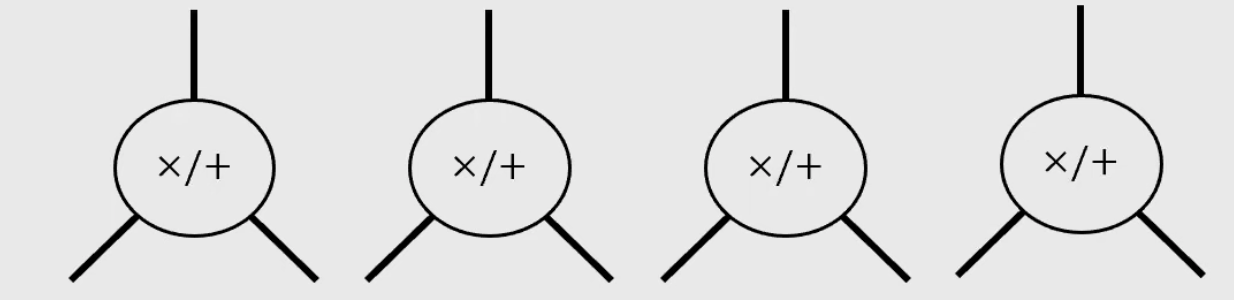

For example that the output of the first gate `c[0]=var1` is an input to the second gate `a[1]=var1`. So it is an essential part of PLONK to provide a proof that the wires (`a`,`b`,`c` vector values) are connected. 

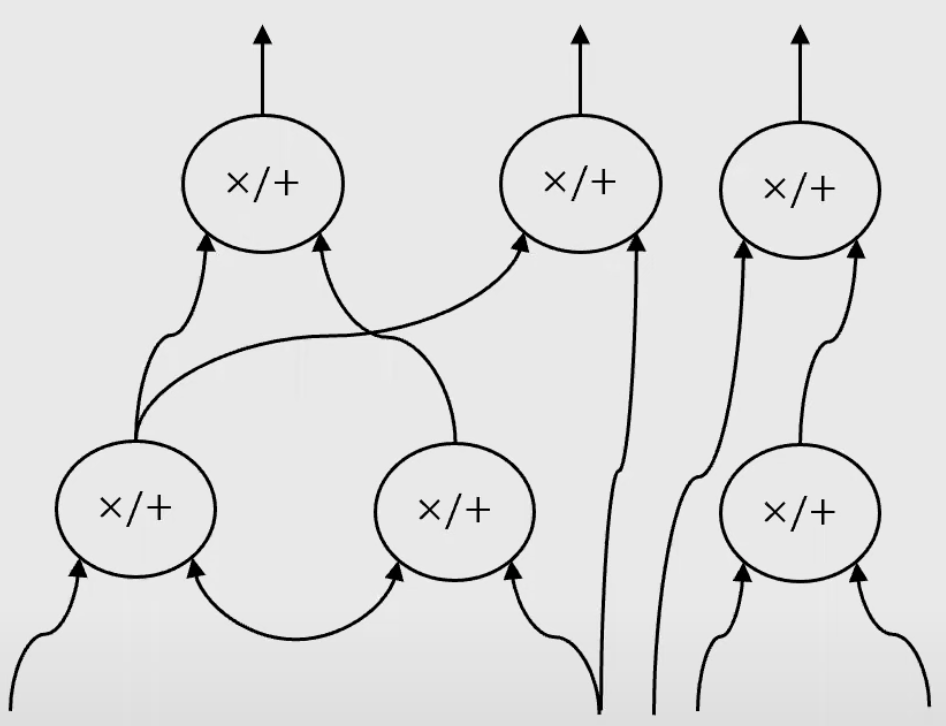

This is done using permutations and explained very well in the Copy Constrainst section of [Vitaliks blog](https://vitalik.ca/general/2019/09/22/plonk.html). So in our example, we take the combined wire vectors `a+b+c` and look at entries that repeat somewhere. If we find a repetition, we swap the indices. e.g. `wires[0] = wire[8]` so we set `permutation[0] = 8` and `permutation[8] = 0`. Note that `permutation[8]` will be swapped again because there are more repetitions of its value on position `9` and `10`.

In [ ]:
def permute_indices(wires):
    size = len(wires)
    permutation = [i + 1 for i in range(size)]
    for i in range(size):
        for j in range(i+1, size):
            if wires[i] == wires[j]:
                permutation[i], permutation[j] = permutation[j], permutation[i]
                break
    return permutation

permutation = permute_indices(wires)

# Compare the permuation values to the wire values.
print(wires)
print(permutation)

The information gathered so far is sufficient to construct the PLONK setup

## 3. Setup Phase
The setup is performed by a trusted third party or a multiparty computation. The inputs for the setup are the gates vector, the permutation vector and the public inputs. The purpose of the setup is to create a random and hidden evaluation point for our polynomials and to take some computational work off the shoulders of the verifier.

### Gate polynomials
As a first step, we convert the gate "switches" $Q_l, Q_m, Q_r, Q_o, Q_c$ into polynomials. In Lagrange form, this is very easy:

In [ ]:
# Transponse the matrix containing the gates values so we can use the rows as evaluations of our polynomials over the ROOTS
gates_matrix = list(zip(*gates_matrix))
q_L = PolyEvalRep(ROOTS, [Fp(i) for i in gates_matrix[0]])
q_R = PolyEvalRep(ROOTS, [Fp(i) for i in gates_matrix[1]])
q_M = PolyEvalRep(ROOTS, [Fp(i) for i in gates_matrix[2]])
q_O = PolyEvalRep(ROOTS, [Fp(i) for i in gates_matrix[3]])
q_C = PolyEvalRep(ROOTS, [Fp(i) for i in gates_matrix[4]])
Qs = [q_L, q_R, q_M, q_O, q_C]

### Public input polynomial
Next we take the public input and create a  polynomial that vanishes on all `ROOTS`, except for the position of the public input gate where it evaluates to the public input.

In [ ]:
public_input = [Fp(0) for i in range(len(ROOTS))]
for i in L:
    public_input[i] = Fp(-p_i)
p_i_poly = PolyEvalRep(ROOTS, public_input)

### Permutation Polynomial
We are looking for polynomials that we evaluate over our `ROOTS` and which return two sets of `x` values. These `x` values are in turn later used as domains for other polynomials which return the wire values and the permuted wire values. If the prover is honest, the wire values and the permuted wire values are identical. 

The first set of polynomials would just return the identity values for the lenght of the wires vector. We are using roots of unity, so instead of the identity values being `1, 2, ... 3n` we have our roots of unity for the first `n` values. For the values from `n` to `3n`, we use distinct cosets by just picking a random high order element `k` and multiplying.

We then permute the values of the identiy domain according to the permuation derived above. We generate polynomials out of those values.

In [ ]:
def random_fp():
    return randfield(Fp)

# We generate domains on which we can later evaluate the wires polynomials
k = random_fp()
id_domain_a = ROOTS
id_domain_b = [k * root for root in ROOTS]
id_domain_c = [k**2 * root for root in ROOTS]
id_domain = id_domain_a + id_domain_b + id_domain_c

# We permute the positions of the domain generated above
perm_domain = [id_domain[i - 1] for i in permutation]
perm_domain_a = perm_domain[:n]
perm_domain_b = perm_domain[n: 2*n]
perm_domain_c = perm_domain[2*n:3*n]

# Generate polynomials that return the permuted index when evaluated on the
# domain
S_sigma_1 = PolyEvalRep(ROOTS, perm_domain_a)
S_sigma_2 = PolyEvalRep(ROOTS, perm_domain_b)
S_sigma_3 = PolyEvalRep(ROOTS, perm_domain_c)
Ss = [S_sigma_1, S_sigma_2, S_sigma_3]

perm_precomp = [id_domain, perm_domain, k, Ss]

### CRS and precomputation
In order to create a random and hidden evaluation point, we start with a random element `tau` (which is the toxic waste and has to be destroyed). We raise this element successively to the `i`-th power, `n+3` times. The result is a vector of elements that we only need to multiply with any polynomials coefficients to get an efficient evaluation on the random, unknown point. We call that the common reference string or CRS. The number of points we need depends on the highest degree polynomials in the protocol.

In [ ]:
# We perform the trusted setup
tau = random_fp()
CRS = [G * (tau ** i) for i in range(n + 3)]

The verifier will later need the evaluation of the polynomials we constructed above over the CRS. This is an expensive calculation which we can take off his shoulders here so we calculate these. We don't care about computational effort for the setup phase.

In [ ]:
# Evaluate a polynomial in exponent
def evaluate_in_exponent(powers_of_tau, poly):
    assert poly.degree() < len(powers_of_tau)
    return sum([powers_of_tau[i] * poly.coefficients[i] for i in
                range(poly.degree()+1)], G*0)

q_exp = [evaluate_in_exponent(CRS, q.to_coeffs()) for q in Qs]
s_exp = [evaluate_in_exponent(CRS, s.to_coeffs()) for s in Ss]
x_exp = G2 * tau
verifier_preprocessing = [q_exp, s_exp, x_exp]

This is the end of the setup phase. The output of this phase is `[CRS, Qs, p_i_poly, perm_precomp, verifier_preprocessing]` and is publicly available.

## Prover Phase
The prover knows a solution to our example problem: `x=3`. He plugs this value into the wires to get the witness. Note that we can check if the witness is correct by plugging the witness into the equation: $ (Q_{L_i}) a_i + (Q_{R_i}) b_i + (Q_{O_i}) c_i + (Q_{M_i})a_ib_i + Q_{C_i} = 0$

In [ ]:
witness = [3, 9, 27, 1, 1, 30, 0, 0,
           3, 3, 3, 5, 35, 5, 0, 0,
           9, 27, 30, 5, 35, 35, 0, 0]
witness = [Fp(i) for i in witness]

# lets check if the witness is correct
def eval_poly(poly, domain, shift=Fp(1)):
    poly_coeff = poly.to_coeffs()
    eval = []
    for j in range(len(domain)):
        eval += [sum([(domain[j] * shift) ** i * poly_coeff.coefficients[i]
                 for i in range(poly_coeff.degree()+1)])]
    return eval

# We are checking that the first gate is correct. The result should be zero.
witness_check = (eval_poly(q_L, [ROOTS[0]])[0] * witness[0] +
                 eval_poly(q_R, [ROOTS[0]])[0] * witness[8] +
                 eval_poly(q_O, [ROOTS[0]])[0] * witness[16] +
                 eval_poly(q_M, [ROOTS[0]])[0] * witness[0] * witness[8] +
                 eval_poly(q_C, [ROOTS[0]])[0] * witness[0] +
                 eval_poly(p_i_poly, [ROOTS[0]])[0])
# note that we also have to deduct the public input here
print(witness_check)

### Preparation
The prover algorithm consists of five rounds of communication between the prover and verifier. Following the paper, we are using the Fiat Shamir heuristic where communication with the verifier is simulated using a random oracle for verifier answers. The log of the communication between the prover and simulated verifier is the transcript.

The highest order polynomials we will deal with is of degree `4n+5`. The Lagrange polynomials we have so far are represented by only `n` points. So we need to extend our evaluation domain to the next power of two, which is `8n`. Vitalik provides a good explanation of this domain extension in his STARK blog series. We generate a couple of polynomials for preperation. One that evaluates to the witness over the `ROOTS` and the vanishing polynomial, i.e. the one that evaluates to zero on all `ROOTS`. Because we use roots of unity, this polynomial can be very efficiently calculated as: $x^n-1$. This polynomial is an essential part of many SNARKs and STARKs. Roughly speaking, the claim we want to prove is represented by a polynomial that, if we are honest, vanishes on the ROOTS, so if we divide that by the vanishing polynomial we should get a low degree polynomial without remainder.


Common preprocessed input:

$n,(x·[1]_1,...,x^{n+5} ·[1]_1),(q_{M_i},q_{L_i},q_{R_i},q_{O_i},q_{C_i})^n_{i=1},σ∗, $
$\\ q_M(X) = \sum_{i=1}^{n} q_{M_i}L_i(X)$,
$\\ q_L(X) = \sum_{i=1}^{n} q_{L_i}L_i(X)$,
$\\ q_R(X) = \sum_{i=1}^{n} q_{R_i}L_i(X)$,
$\\ q_O(X) = \sum_{i=1}^{n} q_{O_i}L_i(X)$,
$\\ q_C(X) = \sum_{i=1}^{n} q_{C_i}L_i(X)$, 
$\\ S_{σ1}(X) = \sum_{i=1}^{n}  σ^∗(i)L_i(X)$, 
$\\ S_{σ2}(X) = \sum_{i=1}^{n}  σ^∗(n + i)L_i(X), $
$\\ S_{σ3}(X) = \sum_{i=1}^{n}  σ^∗(2n + i)L_i(X)$

In [ ]:
# to-do: remove the polys represented with 2n points and convert them to 8n

def vanishing_poly(omega, n):
    # For the special case of evaluating at all n powers of omega,
    # the vanishing poly has a special form.
    #  t(X) = (X-1)(X-omega)....(X-omega^(n-1)) = X^n - 1
    return Poly([Fp(-1)] + [Fp(0)] * (n - 1) + [Fp(1)])


# polys represented with n points
omega = omega_base ** (2 ** 32 // n)
ROOTS = [omega ** i for i in range(n)]
PolyEvalRep = polynomialsEvalRep(Fp, omega, n)
witness = [Fp(i) for i in witness]
witness_poly_a = PolyEvalRep(ROOTS, witness[:n])
witness_poly_b = PolyEvalRep(ROOTS, witness[n:n*2])
witness_poly_c = PolyEvalRep(ROOTS, witness[2*n:])
vanishing_pol_coeff = vanishing_poly(omega, n)

# polys represented with 2*n points
omega2 = omega_base ** (2 ** 32 // (2 * n))
PolyEvalRep2 = polynomialsEvalRep(Fp, omega2, 2 * n)
vanishing_poly_ext = PolyEvalRep2.from_coeffs(vanishing_pol_coeff)
witness_poly_a_ext = PolyEvalRep2.from_coeffs(witness_poly_a.to_coeffs())
witness_poly_b_ext = PolyEvalRep2.from_coeffs(witness_poly_b.to_coeffs())
witness_poly_c_ext = PolyEvalRep2.from_coeffs(witness_poly_c.to_coeffs())

# polys represented with 8*n points
omega3 = omega_base ** (2 ** 32 // (8 * n))
PolyEvalRep3 = polynomialsEvalRep(Fp, omega3, 8 * n)
roots3 = [omega3 ** i for i in range(8 * n)]
S1, S2, S3 = Ss
S1_ext3 = PolyEvalRep3.from_coeffs(S1.to_coeffs())
S2_ext3 = PolyEvalRep3.from_coeffs(S2.to_coeffs())
S3_ext3 = PolyEvalRep3.from_coeffs(S3.to_coeffs())
p_i_poly_ext3 = PolyEvalRep3.from_coeffs(p_i_poly.to_coeffs())
qs_ext3 = [PolyEvalRep3.from_coeffs(q.to_coeffs()) for q in Qs]
q_L_ext3, q_R_ext3, q_M_ext3, q_O_ext3, q_C_ext3 = qs_ext3

### Round 1
In the first round, we evaluate the wire polynomials in the exponent, i.e. we provide an encrypted evaluation to the verifier. We multiply the `CRS` values with the coefficients of the wire polynomials. But before we do that we add a "blinding" term to it, which has the sole purpose to obfuscate in order to make the protocol "zero knowledge". You could leave that part away if you dont care about privacy. Note that we multiply the blinding term with the vanishing polynomial before we add it to the witness polynomial. This ensures that when we evaluate the entire thing on the `ROOTS` we still get the wire values and not some random value.


Generate random blinding scalars $(b_1, . . . , b_9) ∈ F$

Compute wire polynomials $a(X), b(X), c(X)$ :

$a(X) = (b_1X + b_2)Z_H(X) + \sum_{i=1}^{n} w_iL_i(X)$

$b(X) = (b_3X + b_4)Z_H(X) + \sum_{i=1}^{n} w_{n+i}L_i(X)$

$c(X) = (b_5X + b_6)Z_H(X) + \sum_{i=1}^{n} w_{2n+i}L_i(X)$

Compute $[a]_1 := [a(x)]_1 , [b]_1 := [b(x)]_1 , [c]_1 := [c(x)]_1 $

First output of $P$ is $([a]_1, [b]_1, [c]_1)$.

In [ ]:
def random_fp_seeded(seeded):
    random.seed(seeded)
    return randfield(Fp)


# Generate "random" blinding scalars
rand_scalars = [random_fp_seeded("1234") for i in range(9)]

# Generate polys with the random scalars as coefficients and convert to
# evaluation representation. These are needed for zero knowledge to
# obfuscate the witness.
a_blind_poly_ext = Poly([rand_scalars[1], rand_scalars[0]])
b_blind_poly_ext = Poly([rand_scalars[3], rand_scalars[2]])
c_blind_poly_ext = Poly([rand_scalars[5], rand_scalars[4]])
a_blind_poly_ext = PolyEvalRep2.from_coeffs(a_blind_poly_ext)
b_blind_poly_ext = PolyEvalRep2.from_coeffs(b_blind_poly_ext)
c_blind_poly_ext = PolyEvalRep2.from_coeffs(c_blind_poly_ext)

# These polynomals have random evaluations at all points except ROOTS where
# they evaluate to the witness
a_poly_ext = a_blind_poly_ext * vanishing_poly_ext + witness_poly_a_ext
b_poly_ext = b_blind_poly_ext * vanishing_poly_ext + witness_poly_b_ext
c_poly_ext = c_blind_poly_ext * vanishing_poly_ext + witness_poly_c_ext

# Evaluate the witness polynomials in the exponent using the CRS
a_eval_exp = evaluate_in_exponent(CRS, a_poly_ext.to_coeffs())
b_eval_exp = evaluate_in_exponent(CRS, b_poly_ext.to_coeffs())
c_eval_exp = evaluate_in_exponent(CRS, c_poly_ext.to_coeffs())

first_output = [a_eval_exp, b_eval_exp, c_eval_exp]
print("Round 1 Finished with output: ", first_output)

### Round 2
The imaginary verifier responds to the first round output with two permutation challenges, which we simulate by hashing the transcript. Given the two challenges, we calculate the accumulator polynomial. The first summand of it is again only needed for zero knowledge and can be left out if this is not necessary. The second `accumulator_poly_eval` is a huge term that deserves its own function. Read Vitalik's blog on PLONK in the Copy Constraints section to get an in depth understanding of what it does happens. Tl; dr: the polynomial accumulates linear combinations of the x and y values. If we apply this to a set of x and y values where the xs are permuted for identical ys, we get the same result. 

This is IMO the most difficult part to understand about PLONK. After staring at the accumulator_factor(), the PLONK paper and Vitaliks blog for a while, you will notice that the accumulatof_factor() combines the polynomials that Vitalik calls "coordinate pair accumulators" `p_a * p_b * p_c` and `p_a'* p_b' * p_c'` into one polynomial by dividing the two terms. In the next step it will become clear why. 

We commit to this polynomial by evaluating it with the CRS. This evaluation point is the output of round 2.



Compute permutation challenges $(β, γ) ∈ F$:

$β = H(transcript, 0), γ = H(transcript, 1)$

Compute permutation polynomial $z(X)$:

$z(X) = (b_7X^2 + b_8X + b_9)Z_H(X)$
$\\ +L_1(X)+\sum_{i=1}^{n-1}(L_{i+1}(X)\prod_{j=1}^{i} \dfrac{(w_j+βω^j+γ)(w_{n+j}+βk_1ω^j+γ)(w_{2n+j}+βk_2ω^j+γ)}{(w_j+σ^*(j)β+γ)(w_{n+j}+σ^*(n+j)β+γ)(w_{2n+j}+σ^*(2n+j)β+γ)})$

Compute $[z]_1 := [z(x)]_1$

Second output of $P$ is $([z]_1)$


In [ ]:
def accumulator_factor(n, i, witness, beta, id_domain, perm_domain, gamma):
    res = Fp(1)
    for j in range(i+1):
        nom_1 =   witness[j]         + beta * id_domain[j]     + gamma
        denom_1 = witness[j]         + beta * perm_domain[j]     + gamma

        nom_2 =   witness[n + j]     + beta * id_domain[n+j]   + gamma
        denom_2 = witness[n + j]     + beta * perm_domain[n+j]   + gamma

        nom_3 =   witness[2 * n + j] + beta * id_domain[2*n+j] + gamma
        denom_3 = witness[2 * n + j] + beta * perm_domain[2*n+j] + gamma
        res *= (nom_1 / denom_1) * (nom_2 / denom_2) * (nom_3 / denom_3)
    return res


# Compute permutation challenges from imaginary verifier
beta = random_fp_seeded(str(first_output) + "0")
gamma = random_fp_seeded(str(first_output) + "1")

# Compute permutation polynomial. z_1 is the blinding summand needed for ZK
z_1 = Poly([rand_scalars[8], rand_scalars[7], rand_scalars[6]])
z_1 = PolyEvalRep2.from_coeffs(z_1)
z_1 = z_1 * vanishing_poly_ext

accumulator_poly_eval = [Fp(1)]
accumulator_poly_eval += [accumulator_factor(n,
                                             i,
                                             witness, beta,
                                             id_domain,
                                             perm_domain,
                                             gamma)
                          for i in range(n-1)]
accumulator_poly = PolyEvalRep(ROOTS, accumulator_poly_eval)
accumulator_poly = z_1 + PolyEvalRep2.from_coeffs(accumulator_poly.to_coeffs())
second_output = evaluate_in_exponent(CRS, accumulator_poly.to_coeffs())
print("Round 2 Finished with output: ", second_output)

### Round 3
This round has a lot going on. Again, we first hash the transcript of the previous rounds to generate a verifier challenge. Next we create a shifted accumulator polynomial by multiplying its argument with the root of unity. This is because the accumulator polynomial is constructed using two constraints: `p(0)=1` and `p(x+1) = p(x) * accumulator_factor`. Since we are using roots of unity, the shift `x+1` translates to `x * ROOTS[1]`.

Given this, we generate a polynomial `t`, which represents the entire statement we want to prove:
The first part of `t` is just the witness applied to the gates equation. This will evaluate to zero over all `ROOTS` if we have calculated all individual gates correctly. 

The second, third, and fourth part of `t` are checking the accumulator polynomial constraints. The third part uses the shift we generated above. We have `p(x+1) = p(x) * accumulator_factor` where accumulator factor is `p_a * p_b * p_c` `/`  `p_a'* p_b' * p_c'`. Multiplied by `p_a'* p_b' * p_c'`, the denominator cancels out. We subtract the third summand from the second summand of `t` which is `p_a * p_b * p_c * accumulator_factor`, so that part cancels out too. The fourth summand of `t` deducts `1` from the polynomial at `x=0` to ensure the constraint `p(0)=1` is satisfied. If the prover has connected all wires correctly, it all cancels out and also evaluate to zero on all `ROOTS`.

Adding up all terms of `t` results in a polynomial that evaluates to zero over all ROOTS, if the prover knows a correct solution to the problem. 

The prover now divides this polynomial by the vanishing polyomial, which works without residue only if he is in possession of the correct nominator of `t`. Try to change something in the witness above and check the degree of the resulting polynomial division. Note that we use a special division algorithm here to avoid division by zero. 

Lastly, we split up the result into three polynomials of degree <n+3 by factoring out x^(n+2) and x^(2n+4). We return evaluations of these three polynomials at the CRS.


Compute quotient challenge $α ∈ F$ :

$α = H(transcript)$

Compute quotient polynomial $t(X)$ :

$t(X) =(a(X)b(X)q_M(X) + a(X)q_L(X) + b(X)q_R(X) + c(X)q_O(X) + PI(X) + q_C(X))\dfrac{1}{Z_H(X)}$
$\\+((a(X) + βX + γ)(b(X) + βk_1X + γ)(c(X) + βk_2X + γ)z(X)) \dfrac{α}{Z_H(X)}$
$\\- ((a(X) + βS_{σ1}(X) + γ)(b(X) + βS_{σ2}X) + γ)(c(X) + βS_{σ3}(X) + γ)z(Xω)) \dfrac{α}{Z_H(X)}$
$\\+(z(X)−1)L_1(X)\dfrac{α^2}{Z_H(X)}$

Split $t(X)$ into degree $< n$ polynomials $t'_{lo}(X)$,$t'_{mid}(X)$ and $t'_{hi}(X)$ of degree at most
$n + 5$, such that

$t(X) = t'_{lo}(X) + X^nt'_{mid}(X) + X^{2n}t'_{hi}(X)$

Now choose random scalars $b_{10}, b_{11} ∈ F$ and define

$t_{lo}(X) := t'_{lo}(X) + b_{10}X^n, t_{mid}(X) := t'_{mid}(X) − b_{10} + b_{11}X^n, t_{hi}(X) := t'_{hi}(X) − b_{11}$

Note that we have $t(X) = t_{lo}(X) + X^nt_{mid}(X) + X^{2n}t_{hi}(X)$.

Compute $[t_{lo}]_1 := [t_{lo}(x)]_1 , [t_{mid}]_1 := [t_{mid}(x)]_1 , [t_{hi}]_1 := [t_{hi}(x)]_1$ 

Third output of $P$ is $([t_{lo}]_1, [t_{mid}]_1, [t_{hi}]_1)$

In [ ]:
alpha = random_fp_seeded(str(first_output) + str(second_output))

accumulator_poly_ext3 = PolyEvalRep3.from_coeffs(accumulator_poly.to_coeffs())

# The third summand of t has the accumulator poly evaluated at a shift
accumulator_poly_shift_evaluations = eval_poly(accumulator_poly,
                                               roots3,
                                               ROOTS[1])
accumulator_poly_ext3_shift = PolyEvalRep3(roots3,
                                           accumulator_poly_shift_evaluations)

a_poly_ext3 = PolyEvalRep3.from_coeffs(a_poly_ext.to_coeffs())
b_poly_ext3 = PolyEvalRep3.from_coeffs(b_poly_ext.to_coeffs())
c_poly_ext3 = PolyEvalRep3.from_coeffs(c_poly_ext.to_coeffs())

id_poly_1_ext3 = PolyEvalRep3.from_coeffs(Poly([gamma, beta]))
id_poly_2_ext3 = PolyEvalRep3.from_coeffs(Poly([gamma, beta * k]))
id_poly_3_ext3 = PolyEvalRep3.from_coeffs(Poly([gamma, beta * k**2]))

gamma_poly = PolyEvalRep3.from_coeffs(Poly([gamma]))
L_1 = PolyEvalRep(ROOTS, [Fp(1)] + [Fp(0) for i in range(len(ROOTS)-1)])

# Compute quotient polynomial: we are dividing by the vanishing poly which
# has zeros at n roots so we need to do division by swapping to a coset
# first summand should have degree 3n+1, second and third should have
# degree 4n + 5
t = ((a_poly_ext3 * b_poly_ext3 * q_M_ext3) +
     (a_poly_ext3 * q_L_ext3) +
     (b_poly_ext3 * q_R_ext3) +
     (c_poly_ext3 * q_O_ext3) +
     q_C_ext3 + p_i_poly_ext3)

# to-do print a check that it evaluates to zero over roots

t += ((a_poly_ext3 + id_poly_1_ext3) *
      (b_poly_ext3 + id_poly_2_ext3) *
      (c_poly_ext3 + id_poly_3_ext3) * accumulator_poly_ext3 * alpha)

t -= ((a_poly_ext3 + S1_ext3 * beta + gamma_poly) *
      (b_poly_ext3 + S2_ext3 * beta + gamma_poly) *
      (c_poly_ext3 + S3_ext3 * beta + gamma_poly) *
      accumulator_poly_ext3_shift * alpha)

t += ((accumulator_poly_ext3 - PolyEvalRep3.from_coeffs(Poly([Fp(1)]))) *
      PolyEvalRep3.from_coeffs(L_1.to_coeffs()) * alpha ** 2)

# to-do print a check that it evaluates to zero over roots

t = PolyEvalRep3.divideWithCoset(t.to_coeffs(), vanishing_pol_coeff)
# to-do print a check that it evaluates to zero over roots
# to-do print a degree check

t_coeff = t.coefficients

# We split up the polynomial t in three polynomials so that:
# t= t_lo + x^n*t_mid + t^2n*t_hi
# I found that n has actually to be (n+2) to accomodate the CRS because
# t can be of degree 4n+5
t_lo = Poly(t_coeff[:n+2])
t_mid = Poly(t_coeff[n+2:2*(n+2)])
t_hi = Poly(t_coeff[2*(n+2):])

t_lo_eval_exp = evaluate_in_exponent(CRS, t_lo)
t_mid_eval_exp = evaluate_in_exponent(CRS, t_mid)
t_hi_eval_exp = evaluate_in_exponent(CRS, t_hi)

third_output = [t_lo_eval_exp, t_mid_eval_exp, t_hi_eval_exp]
print("Round 3 Finished with output: ", third_output)

### Round 4
The simulated verifier again hashes the transcript to send a challenge point at which they want the commited polynomials to be challenged. Now is a good time to re-read [how Kate commitments work](https://dankradfeist.de/ethereum/2020/06/16/kate-polynomial-commitments.html) tl; dr: `f(z) = y` means that `f(x)-y` is divisible by `x-z` so if you can provide the quotient you are likely to actually have that polynomial. In our case `zeta` below is `z` and e.g. `a_zeta` would be `y`.


Compute evaluation challenge $𝔷 ∈ F$ :

$𝔷 = H(transcript)$

Compute opening evaluations:
$\\\bar{a}  = a(𝔷), \bar{b} = b(𝔷),\bar{c}= c(𝔷), \bar{s}_{σ1} = S_{σ1}(𝔷), \bar{s}_{σ2} = S_{σ2}(𝔷),\bar{z}_ω = z ( 𝔷 ω )$

Fourth output of $P$ is $(\bar{a }, \bar{b},\bar{c }, \bar{s}_{σ1}, \bar{s}_{σ2},\bar{z }_ω)$

In [ ]:
# Compute the evaluation challenge
zeta = random_fp_seeded(str(first_output) +
                        str(second_output) +
                        str(third_output))

# Compute the opening evaluations
a_zeta = eval_poly(a_poly_ext, [zeta])[0]
b_zeta = eval_poly(b_poly_ext, [zeta])[0]
c_zeta = eval_poly(c_poly_ext, [zeta])[0]
S_1_zeta = eval_poly(S1, [zeta])[0]
S_2_zeta = eval_poly(S2, [zeta])[0]
t_zeta = eval_poly(PolyEvalRep3.from_coeffs(t), [zeta])[0]
accumulator_shift_zeta = eval_poly(accumulator_poly_ext3,
                                   [zeta * ROOTS[1]])[0]

# Compute linearisation polynomial
r = (q_M_ext3 * a_zeta * b_zeta +
     q_L_ext3 * a_zeta +
     q_R_ext3 * b_zeta +
     q_O_ext3 * c_zeta +
     q_C_ext3)
r += (accumulator_poly_ext3 *
      (a_zeta + beta * zeta + gamma) *
      (b_zeta + beta * k * zeta + gamma) *
      (c_zeta + beta * (k ** 2) * zeta + gamma) * alpha)
r -= (S3_ext3 *
      (a_zeta + beta * S_1_zeta + gamma) *
      (b_zeta + beta * S_2_zeta + gamma) *
      alpha * beta * accumulator_shift_zeta)
r += accumulator_poly_ext3 * eval_poly(L_1, [zeta])[0] * alpha ** 2

# Evaluate r at zeta
r_zeta = eval_poly(r, [zeta])[0]

fourth_output = [a_zeta, b_zeta, c_zeta, S_1_zeta, S_2_zeta,
                 accumulator_shift_zeta, t_zeta, r_zeta]
print("Round 4 Finished with output: ", fourth_output)

### Round 5


Compute opening challenge $v ∈ F$ :

$v = H(transcript)$

Compute linearisation polynomial $r(X)$ :

$r(X)=$
$\\ [\bar{a}\bar{b}  · q_M (X) + \bar{a}  · q_L(X) +\bar{b}  · q_R(X) + \bar{c}  · q_O(X) + PI(𝔷) + q_C(X)]$
$\\ +α[(\bar{a} + β_𝔷 + γ)( \bar{b} + β_{k1𝔷} + γ)(\bar{c }+ β_{k2𝔷} + γ) · z(X)$
$\\ -(\bar{a}  + β\bar{s}_{σ1} + γ)( \bar{b} + β\bar{s}_{σ2} + γ)(\bar{c}+ β · S_{σ3}(X) + γ)\bar{z}_ω]$
$\\ +α^2 [(z(X) − 1)L_1(𝔷)]$
$\\ −Z_H (𝔷) · (t_{lo}(X) + 𝔷^n t_{mid}(X) + 𝔷^{2n}t_{hi}(X))$

Compute opening proof polynomial $W_𝔷(X)$ :

$W_𝔷(X)= \dfrac{1}{X-𝔷}\Bigg(r(X) +v(a(X) − \bar{a})  +v^2(b(X)− \bar{b}) +v^3(c(X)−\bar{c}) +v^4(S_{σ1}(X)− \bar{s}_{σ1}) +v^5(S_{σ2}(X)− \bar{s}_{σ2}) \Bigg)$

Compute opening proof polynomial $W_{𝔷ω}(X)$ :

$W_{𝔷ω}(X) = \dfrac{( z ( X ) − \bar{z }_ω )}{X − 𝔷ω}$


Compute $[W_𝔷]_1 := [W_𝔷(x)]_1 ,[W_{𝔷ω}]_1 := [W_{𝔷ω}(x)]_1$

The fifth output of $P$ is $([W_𝔷]_1,[W_{𝔷ω}]_1)$

Return

$π_{SNARK}=\Bigg(  [a]_1,[b]_1,[c]_1,[z]_1,[t_{lo}]_1,[t_{mid}]_1,[t_{hi}]_1,[W_𝔷]_1,[W_{𝔷ω}]_1, \bar{a}, \bar{b},\bar{c} , \bar{s}_{σ1} ,\bar{s}_{σ2} ,\bar{z }_ω \Bigg)$

Compute multipoint evaluation challenge $u ∈ F$ :

$u = H(transcript)$

In [ ]:
# Compute opening challeng
nu = random_fp_seeded(str(first_output) +
                      str(second_output) +
                      str(third_output) +
                      str(fourth_output))

# Compute opening proof polynomial
W_zeta = (PolyEvalRep3.from_coeffs(t_lo) +
          PolyEvalRep3.from_coeffs(t_mid) * zeta ** (n+2) +
          PolyEvalRep3.from_coeffs(t_hi) * zeta ** (2*(n+2)) -
          PolyEvalRep3.from_coeffs(Poly([t_zeta])) +
          (r - PolyEvalRep3.from_coeffs(Poly([r_zeta]))) * nu +
          (a_poly_ext3 - PolyEvalRep3.from_coeffs(Poly([a_zeta]))) * nu ** 2 +
          (b_poly_ext3 - PolyEvalRep3.from_coeffs(Poly([b_zeta]))) * nu ** 3 +
          (c_poly_ext3 - PolyEvalRep3.from_coeffs(Poly([c_zeta]))) * nu ** 4 +
          (S1_ext3 - PolyEvalRep3.from_coeffs(Poly([S_1_zeta]))) * nu ** 5 +
          (S2_ext3 - PolyEvalRep3.from_coeffs(Poly([S_2_zeta]))) * nu ** 6)
W_zeta = W_zeta / PolyEvalRep3.from_coeffs(Poly([-zeta, Fp(1)]))

# Compute the opening proof polynomial
W_zeta_omega = accumulator_poly_ext3 - PolyEvalRep3.from_coeffs(Poly([accumulator_shift_zeta]))
W_zeta_omega = W_zeta_omega / PolyEvalRep3.from_coeffs(Poly([-zeta*ROOTS[1], Fp(1)]))

W_zeta_eval_exp = evaluate_in_exponent(CRS, W_zeta.to_coeffs())
W_zeta_omega_eval_exp = evaluate_in_exponent(CRS, W_zeta_omega.to_coeffs())

fifth_output = [W_zeta_eval_exp, W_zeta_omega_eval_exp]
proof_SNARK = [first_output, second_output, third_output, fifth_output, fourth_output]
print("Round 5 Finished with output: ", fifth_output)

u = random_fp_seeded(str(proof_SNARK))

## Verifier Phase

Verifier preprocessed input:

$[q_M]_1 := q_M(x) · [1]_1, [q_L]_1 := q_L(x) · [1]_1, [q_R]_1 := q_R(x) · [1]_1, [q_O]_1 := q_O(x) · [1]_1, $
$\\ [q_C]_1 := q_C(x) · [1]_1, [s_{σ1}]_1 := S_{σ1}(x) · [1]_1, [s_{σ2}]_1 := S_{σ2}(x) · [1]_1,$
$\\ [s_{σ3}]_1 :=S_{σ3}(x)·[1]_1,x·[1]_2$


In [ ]:
first_output, second_output, third_output, fifth_output, fourth_output = proof_SNARK
a_eval_exp, b_eval_exp, c_eval_exp = first_output
z_eval_exp = second_output
t_lo_eval_exp, t_mid_eval_exp, t_hi_eval_exp = third_output
a_zeta, b_zeta, c_zeta, S_1_zeta, S_2_zeta, accumulator_shift_zeta, t_zeta, r_zeta = fourth_output
W_zeta_eval_exp, W_zeta_omega_eval_exp = fifth_output

q_exp, s_exp, x_exp = verifier_preprocessing
q_L_exp, q_R_exp, q_M_exp, q_O_exp, q_C_exp = q_exp
s_1_exp, s_2_exp, s_3_exp = s_exp

### Step 1 - 3: Typechecks

$V((w_i)_{i∈[l]}, π_{SNARK}):$

1. Validate $([a]_1,[b]_1,[c]_1,[z]_1,[t_{lo}]_1,[t_{mid}]_1,[t_{hi}]_1,[W_𝔷]_1,[W_{𝔷ω}]_1)∈G^9_1$.
2. Validate $(\bar{a}, \bar{b},\bar{c},\bar{s}_{σ1}, \bar{s}_{σ2},\bar{z}_ ω) ∈ F^6$.
3. Validate $(w_i)_{i∈[l]} ∈ F^l$.

In [ ]:
# Check1: Elements in group?
assert type(a_eval_exp) is Group
assert type(b_eval_exp) is Group
assert type(c_eval_exp) is Group
assert type(z_eval_exp) is Group
assert type(t_lo_eval_exp) is Group
assert type(t_mid_eval_exp) is Group
assert type(t_hi_eval_exp) is Group
assert type(W_zeta_eval_exp) is Group
assert type(W_zeta_omega_eval_exp) is Group

# Check2: Elements in field?
assert type(a_zeta) is Fp
assert type(b_zeta) is Fp
assert type(c_zeta) is Fp
assert type(S_1_zeta) is Fp
assert type(S_2_zeta) is Fp
assert type(r_zeta) is Fp
assert type(accumulator_shift_zeta) is Fp

# Check3: Public input in field?
assert type(p_i_poly) == polynomialsEvalRep(Fp, omega, n)


### Step 4: Recompute challenges from transcript
Compute challenges $β, γ, α, z, v, u ∈ F$ as in prover description, from the common inputs, public input, and elements of $π_{SNARK}$.

In [ ]:
# Step4: Recompute challenges from transcript
beta = random_fp_seeded(str(first_output) + "0")
gamma = random_fp_seeded(str(first_output) + "1")
alpha = random_fp_seeded(str(first_output) + str(second_output))
zeta = random_fp_seeded(str(first_output) +
                        str(second_output) +
                        str(third_output))
nu = random_fp_seeded(str(first_output) +
                      str(second_output) +
                      str(third_output) +
                      str(fourth_output))
u = random_fp_seeded(str(proof_SNARK))

### Step 5 - 7: Evaluate polynomials at Zeta

5. Compute zero polynomial evaluation $Z_{H}(𝔷) = 𝔷^n − 1$.
6. Compute Lagrange polynomial evaluation $L_1(𝔷) = \dfrac{ω(𝔷^n−1)}{n(𝔷−ω)}$.
7. Compute public input polynomial evaluation $PI(𝔷) = \sum_{i∈[l]} w_iL_i(𝔷)$.

In [ ]:
# Step5: Evaluate vanishing polynomial at zeta
vanishing_poly_eval = zeta ** n - Fp(1)

# Step6: Evaluate lagrange polynomial at zeta
L_1_zeta = (zeta ** n - Fp(1)) / ((zeta - Fp(1))*n)

# Step7: Evaluate public input polynomial at zeta
p_i_poly_zeta = eval_poly(p_i_poly, [zeta])[0]

### Step 8: Compute quotient polynomial evaluation
To save a verifier scalar multiplication, we split $r$ into its constant and non-constant terms. Compute $r$’s constant term:

$r_0 := PI(𝔷) − L_1(𝔷)α^2 − α(\bar{a} + β\bar{s}_{σ1} + γ)( \bar{b} + β\bar{s}_{σ2} + γ)(\bar{c} + γ)\bar{z}_ω,$

and let $r'(X) := r(X) − r_0$.

In [ ]:
t_zeta = (r_zeta + p_i_poly_zeta -
          (a_zeta + beta * S_1_zeta + gamma) *
          (b_zeta + beta * S_2_zeta + gamma) *
          (c_zeta + gamma) * accumulator_shift_zeta * alpha -
          L_1_zeta * alpha ** 2) / vanishing_poly_eval

### Step 9: Compute first part of batched polynomial commitment

Compute first part of batched polynomial commitment $[D]_1 := [r']_1 + u · [z]_1:$

$[D]_1 :=$

$\bar{a} \bar{b}·[q_M]_1 +\bar{a} ·[q_L]_1 + \bar{b}·[q_R]_1 +\bar{c }·[q_O]_1 +[q_C]_1$
$\\ +((\bar{a}+β_𝔷+γ)( \bar{b}+β_{k1𝔷}+γ)(\bar{c}+β_{k2𝔷}+γ)α+L_1(𝔷)α^2 +u)·[z]_1$
$\\ −(\bar{a} + β\bar{s}_{σ1} + γ)( \bar{b} + β \bar{s}_{σ2} + γ)αβ\bar{z}_ω · [s_{σ3}]_1$
$\\ −Z_H (𝔷)([t_{lo}]_1 + 𝔷^n · [t_{mid}]_1 + z^{2n} · [t_{hi}]_1)$

In [ ]:
D_1_exp = (q_M_exp * a_zeta * b_zeta * nu +
           q_L_exp * a_zeta * nu +
           q_R_exp * b_zeta * nu +
           q_O_exp * c_zeta * nu +
           q_C_exp * nu)
D_1_exp += (z_eval_exp * (
            (a_zeta + beta * zeta + gamma) *
            (b_zeta + beta * k * zeta + gamma) *
            (c_zeta + beta * (k ** 2) * zeta + gamma) * alpha * nu
            + L_1_zeta * (alpha ** 2) * nu + u))
D_1_exp += (s_3_exp *
            (a_zeta + beta * S_1_zeta + gamma) *
            (b_zeta + beta * S_2_zeta + gamma) *
            alpha * beta * accumulator_shift_zeta * nu) * Fp(-1)

### Step 10: Compute full batched polynomial commitment

Compute full batched polynomial commitment $[F]_1$:
        
$[F]_1 := [D]_1 +v·[a]_1 +v^2 ·[b]_1 +v^3 ·[c]_1 +v^4 ·[s_{σ1}]_1 +v^5 ·[s_{σ2}]_1$

In [ ]:
F_1_exp = (t_lo_eval_exp +
           t_mid_eval_exp * zeta ** (n+2) +
           t_hi_eval_exp * zeta ** (2*(n+2)) +
           D_1_exp +
           a_eval_exp * nu ** 2 +
           b_eval_exp * nu ** 3 +
           c_eval_exp * nu ** 4 +
           s_1_exp * nu ** 5 +
           s_2_exp * nu ** 6)

### Step 11: Compute group encoded batch evaluation

Compute group-encoded batch evaluation $[E]_1:$

$[E]_1 := \Bigg(−r_0 + v\bar{a } + v^2 \bar{b} + v^3 \bar{c}) +v^4 \bar{s}_{σ1} +v^5 \bar{s}_{σ2} +u\bar{z}_ω\Bigg) ·[1]_1  $

In [ ]:
E_1_exp = G * (t_zeta +
               nu * r_zeta +
               nu ** 2 * a_zeta +
               nu ** 3 * b_zeta +
               nu ** 4 * c_zeta +
               nu ** 5 * S_1_zeta +
               nu ** 6 * S_2_zeta +
               u * accumulator_shift_zeta)

### Check 12: Batch validate all evaluations via pairing

Batch validate all evaluations:

$e([W_𝔷]_1 +u·[W_{𝔷ω}]_1,[x]_2)\stackrel{?}{=} e(𝔷·[W_𝔷]_1 +u𝔷ω·[W_{𝔷ω}]_1 +[F]_1 −[E]_1,[1]_2)$

In [ ]:
e11 = W_zeta_eval_exp + W_zeta_omega_eval_exp * u
e21 = (W_zeta_eval_exp * zeta + W_zeta_omega_eval_exp * u * zeta * omega +
       F_1_exp + (E_1_exp * Fp(-1)))
assert e11.pair(x_exp) == e21.pair(G2)
print("Verification Successful!")